# Практика застосування лінійної регресії

In [177]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import statsmodels.api as sm
from scipy.stats import zscore
from prophet import Prophet

## EDA датасету California Housing

### Знайомство з даними

In [178]:
california_housing = fetch_california_housing(as_frame=True)
california_housing.data.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


### Визначення цільової змінної

In [179]:
california_housing.target.head()
# Збереження даних у DataFrame
data = california_housing.data
target = california_housing.target

### Перевірка типів даних і відсутніх значень

In [180]:
california_housing.frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


### Розподіл ознак

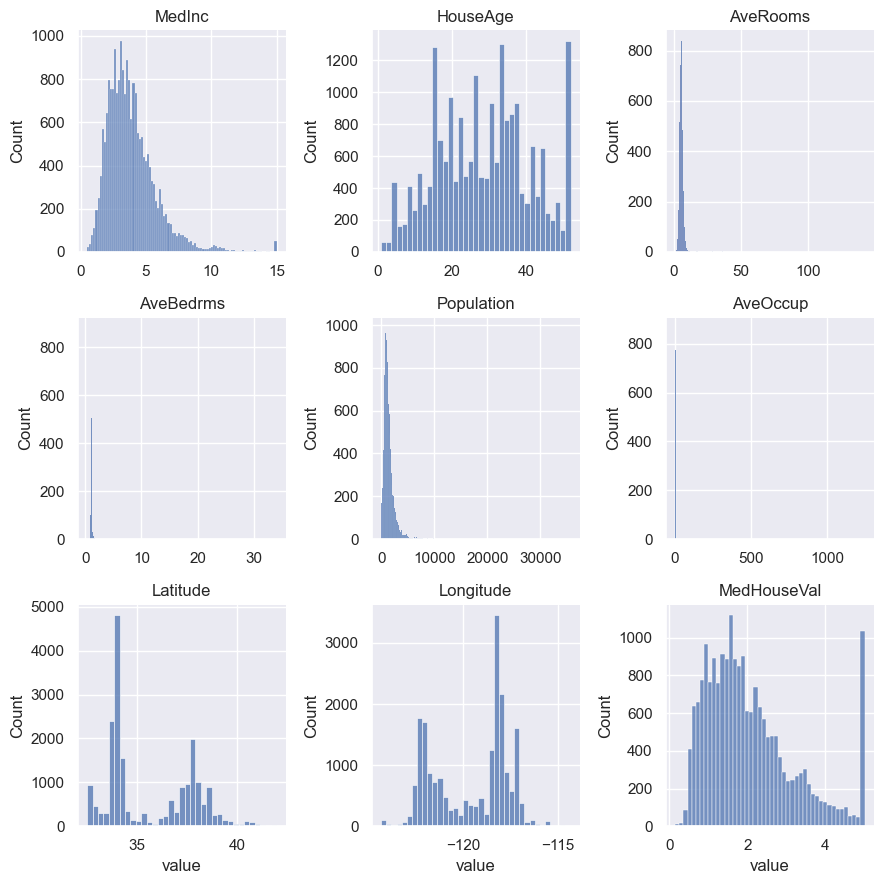

In [181]:
sns.set_theme()

melted = california_housing.frame.melt()

g = sns.FacetGrid(melted,
                  col='variable',
                  col_wrap=3,
                  sharex=False,
                  sharey=False)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    g.map(sns.histplot, 'value')

g.set_titles(col_template='{col_name}')

g.tight_layout()

In [182]:
features_of_interest = ['AveRooms', 'AveBedrms', 'AveOccup', 'Population']
california_housing.frame[features_of_interest].describe()

,AveRooms,AveBedrms,AveOccup,Population
count,20640.000000,20640.000000,20640.000000,20640.000000
mean,5.429000,1.096675,3.070655,1425.476744
std,2.474173,0.473911,10.386050,1132.462122
min,0.846154,0.333333,0.692308,3.000000
25%,4.440716,1.006079,2.429741,787.000000
50%,5.229129,1.048780,2.818116,1166.000000
75%,6.052381,1.099526,3.282261,1725.000000
max,141.909091,34.066667,1243.333333,35682.000000


### Як бачимо, наші спостереження (цільова змінна) є асиметричними й вимірюються в діапазоні від 0.846154	0.333333	0.692308	3.000000 до 141.909091	34.066667	1243.333333	35682.000000.

### Вибір ознак для моделювання

Text(0.5, 1.0, 'Median house value depending of\n their spatial location')

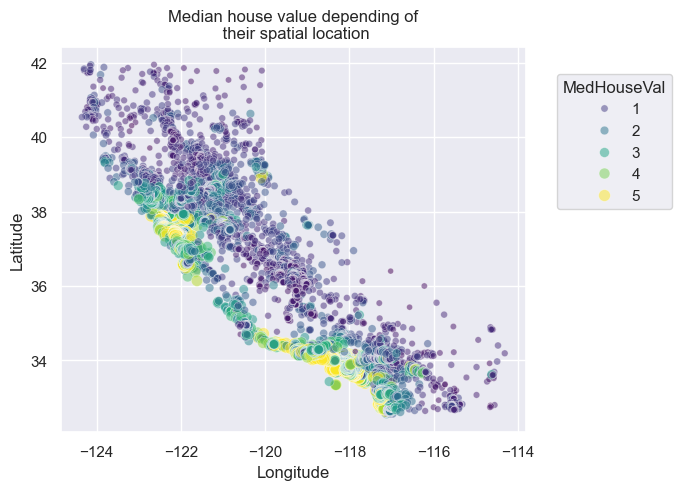

In [183]:
fig, ax = plt.subplots(figsize=(6, 5))

sns.scatterplot(
    data=california_housing.frame,
    x='Longitude',
    y='Latitude',
    size='MedHouseVal',
    hue='MedHouseVal',
    palette='viridis',
    alpha=0.5,
    ax=ax)

plt.legend(
    title='MedHouseVal',
    bbox_to_anchor=(1.05, 0.95),
    loc='upper left')

plt.title('Median house value depending of\n their spatial location')

### Матриця кореляції змінних

<Axes: >

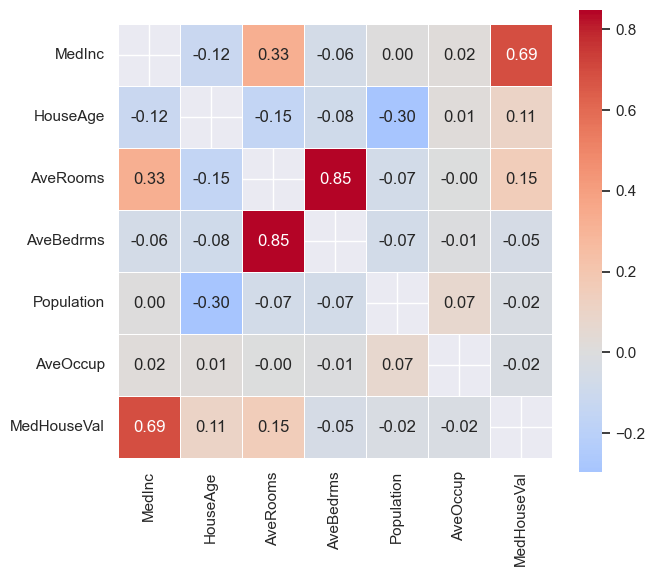

In [184]:
columns_drop = ['Longitude', 'Latitude']
subset = california_housing.frame.drop(columns=columns_drop)

corr_mtx = subset.corr()

mask_mtx = np.zeros_like(corr_mtx)
np.fill_diagonal(mask_mtx, 1)

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(subset.corr(),
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt='.2f',
            linewidth=0.5,
            square=True,
            mask=mask_mtx,
            ax=ax)

## Підготовка і обробка даних

### Очистка даних від викидів

In [185]:
data = california_housing.frame
data_before_cleaning = data.copy()  # Збереження копії даних до очищення від викидів
# Apply zscore to the specified columns
cols_to_clean = ['AveRooms', 'AveBedrms', 'AveOccup', 'Population']
data[cols_to_clean] = data[cols_to_clean].apply(zscore)  # Використання zscore для визначення викидів
data = data[(np.abs(data[cols_to_clean]) < 3).all(axis=1)]  # Видалення рядків, де хоча б одна змінна є викидом



Видалення ознаки з високою кореляцією

In [186]:
correlation_matrix = data.corr()
high_corr_var=np.where(correlation_matrix>0.8)
high_corr_var=[(correlation_matrix.columns[x],correlation_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
for var_pair in high_corr_var:
    data.drop(var_pair[1], axis=1, inplace=True)

In [187]:
# Виведіть колонки DataFrame перед розділенням даних
print(data.columns)


Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal'],
      dtype='object')


### Розбиття на тренувальну і тестову вибірки

In [189]:
# Розділення даних на тренувальну та тестову вибірки, використовуючи оновлені дані
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['MedHouseVal'], axis=1),  # Виключення цільової колонки з даних
    california_housing.target.loc[data.index],  # Використання відповідних цільових значень
    test_size=0.2,
    random_state=42
)

### Нормалізація змінних

In [190]:
scaler = StandardScaler().set_output(transform='pandas').fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [191]:
X_train_scaled.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,1.610800e+04,1.610800e+04,1.610800e+04,1.610800e+04,1.610800e+04,1.610800e+04,1.610800e+04,1.610800e+04
mean,-1.676224e-17,-1.248346e-16,1.058668e-17,1.058668e-17,-1.279224e-17,-9.704458e-18,-1.722100e-15,-8.151744e-16
std,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00
min,-1.773858e+00,-2.240869e+00,-3.507114e+00,-5.444216e+00,-1.644220e+00,-2.448193e+00,-1.450260e+00,-2.367900e+00
25%,-6.876112e-01,-7.974045e-01,-6.751640e-01,-4.671025e-01,-6.811515e-01,-5.624555e-01,-7.992891e-01,-1.106958e+00
50%,-1.764550e-01,4.520411e-03,-6.643338e-02,-1.525954e-01,-2.266418e-01,-1.286644e-01,-6.447421e-01,5.377489e-01
75%,4.568290e-01,6.460603e-01,5.756311e-01,2.172224e-01,4.354681e-01,3.899295e-01,9.709764e-01,7.869470e-01
max,5.862520e+00,1.848948e+00,5.682354e+00,1.070880e+01,4.271775e+00,3.487352e+01,2.951988e+00,2.511397e+00


## Навчання і оцінка моделі

### Побудова моделі

In [192]:
model = LinearRegression().fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

ymin, ymax = y_train.agg(['min', 'max']).values

y_pred = pd.Series(y_pred, index=X_test_scaled.index).clip(ymin, ymax)
y_pred.head()

7969     2.422614
17082    2.668349
5623     1.786005
16934    2.694549
7501     1.490342
dtype: float64

### Оцінювання точності моделі

In [193]:
r_sq = model.score(X_train_scaled, y_train)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'R2: {r_sq:.2f} | MAE: {mae:.2f} | MAPE: {mape:.2f}')

R2: 0.65 | MAE: 0.49 | MAPE: 0.29


In [194]:
pd.Series(model.coef_, index=X_train_scaled.columns)

MedInc        0.836390
HouseAge      0.128985
AveRooms     -0.154966
AveBedrms     0.149326
Population    0.035213
AveOccup     -0.223538
Latitude     -0.921483
Longitude    -0.866068
dtype: float64

### Поліноміальна регресія

In [195]:
# [a, b] -> [1, a, b, a^2, ab, b^2]
poly = PolynomialFeatures(2).set_output(transform='pandas')

Xtr = poly.fit_transform(X_train_scaled)
Xts = poly.transform(X_test_scaled)

model_upd = LinearRegression().fit(Xtr, y_train)
y_pred_upd = model_upd.predict(Xts) # Оцінка моделі
y_pred_upd = pd.Series(y_pred_upd, index=Xts.index).clip(ymin, ymax)

r_sq_upd = model_upd.score(Xtr, y_train) # Обчислення показників
mae_upd = mean_absolute_error(y_test, y_pred_upd)
mape_upd = mean_absolute_percentage_error(y_test, y_pred_upd)

print(f'R2: {r_sq_upd:.2f} | MAE: {mae_upd:.2f} | MAPE: {mape_upd:.2f}') # Виведення результатів

R2: 0.71 | MAE: 0.44 | MAPE: 0.25


In [199]:
from scipy.stats import shapiro

# Перевірка на нормальність після очищення від викидів
stat, p = shapiro(data['AveRooms'])
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
# p-value менше 0.05 може вказувати на те, що дані не є нормально розподіленими.


Statistics=0.979, p-value=0.000


<Axes: xlabel='MedHouseVal', ylabel='None'>

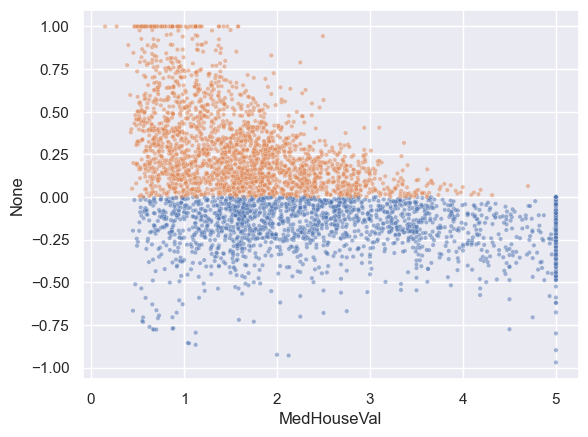

In [203]:
pct_error = (y_pred_upd / y_test - 1).clip(-1, 1)

sns.scatterplot(
    x=y_test,
    y=pct_error,
    hue=pct_error.gt(0),
    alpha=0.5,
    s=10,
    legend=False)

Порівняння метрик для лінійної та поліноміальної регресії:
Лінійна регресія:
До видалення викидів та ознак з високою кореляцією:

R² (коефіцієнт детермінації): 0.61
MAE (середня абсолютна помилка): 0.52
MAPE (середня абсолютна відсоткова помилка): 0.31
Після видалення викидів та ознак з високою кореляцією:

R²: 0.65
MAE: 0.49
MAPE: 0.29
Поліноміальна регресія:
До видалення викидів та ознак з високою кореляцією:

R²: 0.69
MAE: 0.46
MAPE: 0.27
Після видалення викидів та ознак з високою кореляцією:

R²: 0.71
MAE: 0.44
MAPE: 0.25
Аналіз:
Ефект видалення викидів і ознак з високою кореляцією: Видалення викидів і ознак, які мають високу кореляцію, покращило показники для обох типів моделей (лінійної та поліноміальної регресії). Це підтверджує, що видалення не тільки викидів, але й колінійних ознак, може допомогти зменшити шум та переоснащення в моделях, сприяючи точнішому моделюванню.

Порівняння лінійної та поліноміальної регресії: Поліноміальна регресія показує кращі результати за всіма трьома метриками порівняно з лінійною регресією, як до, так і після видалення викидів та ознак з високою кореляцією. Це вказує на те, що поліноміальна модель краще адаптується до складних нелинійних залежностей в даних.

Висновки:
Видалення викидів та колінійних ознак є ефективною стратегією для покращення точності прогнозування, особливо коли присутній великий обсяг даних з потенційними шумами.
Поліноміальна регресія є переважним вибором для цього датасету, оскільки вона забезпечує краще розуміння складних залежностей між змінними, що не можуть бути вловлені лінійною моделлю.
Рекомендується проводити аналіз колініарності та викидів як стандартну частину попереднього аналізу даних перед застосуванням будь-яких прогнозних моделей.